# CP Decomposition

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorly as tl
from tensorly.cp_tensor import CPTensor
from tensorly.tucker_tensor import TuckerTensor, tucker_to_tensor
from tensorly.tenalg import multi_mode_dot
import math
from tensorly.decomposition import parafac, non_negative_parafac
from scipy.interpolate import interp1d
import tlviz
import warnings
from kneed import KneeLocator

## Import tensors

In [42]:
tensor_70_cent = np.load('tensors_center/tensor_70.npy')
tensor_100_cent = np.load('tensors_center/tensor_100.npy')
tensor_200_cent = np.load('tensors_center/tensor_200.npy')
tensor_300_cent = np.load('tensors_center/tensor_300.npy')

## Number of components

In [43]:
# we create a list with the tensors for more efficient coding
tensors_cent = [tensor_70_cent, tensor_100_cent, tensor_200_cent, tensor_300_cent]
tensor_names_cent = ['70', '100', '200', '300']

### CORCONDIA

In [45]:
def visualization_corcondia(model, tensors, tensor_names):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes = axes.flatten()
    
    for i, (tensor, name) in enumerate(zip(tensors, tensor_names)):
        plt.sca(axes[i])
    
        models = {}
        for rank in [1, 2, 3, 4, 5, 6, 7]:
            models[rank] = model(tensor, rank=rank, orthogonalise=True)
        
        ax = tlviz.visualisation.scree_plot(models, tensor, metric="Core consistency")
        ax.set_ylim(0, 105)
        ax.set_title(f"tensor_{name}")
        ax.set_xlabel("Num of Comps.")

        ax.set_xticks([1, 2, 3, 4, 5, 6, 7])

        corcondia_values = [ax.lines[0].get_ydata()[i] for i in [0, 1, 2, 3, 4, 5, 6]]

        second = corcondia_values[1]
        third = corcondia_values[2]
        forth = corcondia_values[3]

        print(f"Corcondia value for Tensor {name}: {second}, {third}, {forth}")
    
    plt.tight_layout()
    plt.show()

Corcondia value for Tensor 70: 99.9999589141364, -9371.792815081759, -33757.781403294095
Corcondia value for Tensor 100: 99.99999960388126, 12.058234902270058, -77.3606794775462
Corcondia value for Tensor 200: 99.99999371324478, -95.27256952886623, -31357.47402034946
Corcondia value for Tensor 300: 99.99999389034676, 77.24385657474723, -22.50453936947943


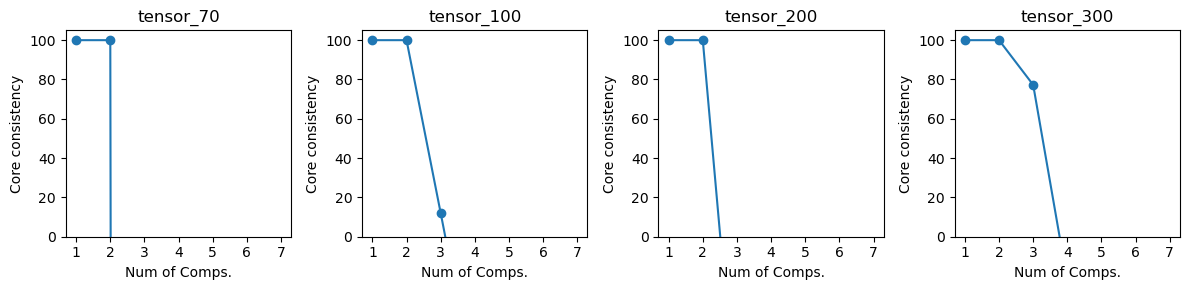

In [46]:
#parafac - tensors_cent
visualization_corcondia(parafac, tensors_cent, tensor_names_cent)

### Reconstruction error

In [6]:
def error(original, res):
    # res is in CP
    if isinstance(res, CPTensor):
        res = res.to_tensor()
    
    # deal with cases when res is Tucker
    if isinstance(res, TuckerTensor):
        res = tucker_to_tensor(res)
        
    assert original.shape == res.shape
    return np.sum((original - res)**2) / np.sum(original**2)

In [40]:
def visualization_error(model, tensors, tensor_names):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes = axes.flatten() 

    warnings.simplefilter("ignore", UserWarning)
    
    for ax, tensor, name in zip(axes, tensors, tensor_names):
        errors = pd.DataFrame(columns=["Num of Comps.", "Reconstruction error"])
        for rr in np.arange(1, 8):
            model_ = model(tensor, rank=rr, orthogonalise=True)
            err = error(tensor, model_)
            errors.loc[len(errors)] = [rr, err]
        print(errors)

        kneedle = KneeLocator(errors["Num of Comps."], errors["Reconstruction error"], curve="convex", direction="decreasing")
        elbow = kneedle.elbow
        
        sns.pointplot(data=errors, x="Num of Comps.", y="Reconstruction error", ax=ax)
        ax.set_title(f"tensor_{name}")
        ax.set_xticklabels(errors["Num of Comps."].astype(int))

        if elbow:
            ax.axvline(elbow - 1, color="red", linestyle="--")
    
    plt.tight_layout()
    plt.show()

   Num of Comps.  Reconstruction error
0            1.0              0.605202
1            2.0              0.415393
2            3.0              0.332647
3            4.0              0.273257
4            5.0              0.237190
5            6.0              0.200000
6            7.0              0.174096
   Num of Comps.  Reconstruction error
0            1.0              0.627010
1            2.0              0.482015
2            3.0              0.395641
3            4.0              0.330941
4            5.0              0.272491
5            6.0              0.222886
6            7.0              0.189783
   Num of Comps.  Reconstruction error
0            1.0              0.637625
1            2.0              0.312233
2            3.0              0.245690
3            4.0              0.213887
4            5.0              0.185337
5            6.0              0.154388
6            7.0              0.125281
   Num of Comps.  Reconstruction error
0            1.0         

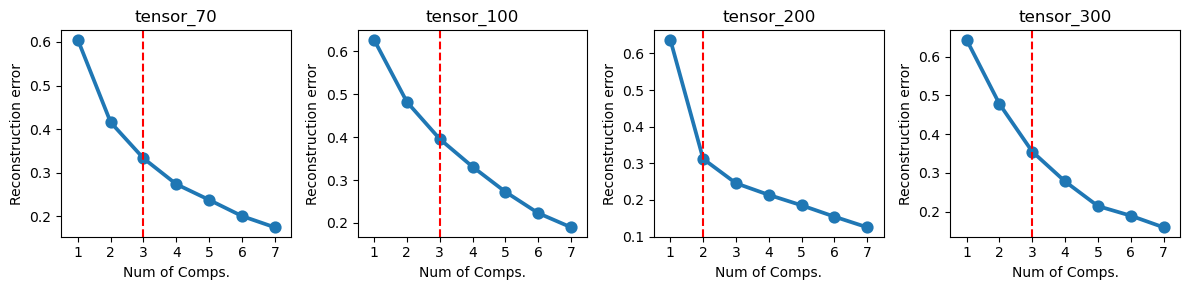

In [44]:
# parafac - tensors_cent
visualization_error(parafac, tensors_cent, tensor_names_cent)

## Decompositions

In [9]:
def decomposition_visualization(factors, patients):
    factor_labels = ["T Cells", "Days", "Patients"]
    x_labels = [range(f.shape[0]) for f in factors]
    
    num_components = factors[0].shape[1]
    
    fig, axes = plt.subplots(num_components, 3, figsize=(15, 4 * num_components))
    
    for component in range(num_components):
        for dim in range(3):
            ax = axes[component, dim]
            if dim == 0 or dim == 2:
                ax.bar(x_labels[dim], factors[dim][:, component], color='royalblue', alpha=0.8)
            else:
                ax.plot(x_labels[dim], factors[dim][:, component], marker='o', linestyle='-')
            ax.set_title(f"Component {component+1} - {factor_labels[dim]}")
            ax.set_xlabel(factor_labels[dim])
            ax.set_ylabel("Weight")
            if dim == 1:
                time_labels = [t * 10 for t in x_labels[dim]]
                ax.set_xticks(x_labels[dim])
                ax.set_xticklabels(time_labels)
                if len(time_labels) > 29:
                    step = 6
                elif len(time_labels) > 19:
                    step = 4
                elif len(time_labels) > 9:
                    step = 2 
                else:
                    step = 1 
                
                ax.set_xticks(x_labels[dim][::step])  # Reduce number of ticks
                ax.set_xticklabels(time_labels[::step]) 
            if dim == 2:
                ax.set_xticks(range(len(patients)))
                ax.set_xticklabels(patients, rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()

### Tensor 70_cent

#### PARAFAC

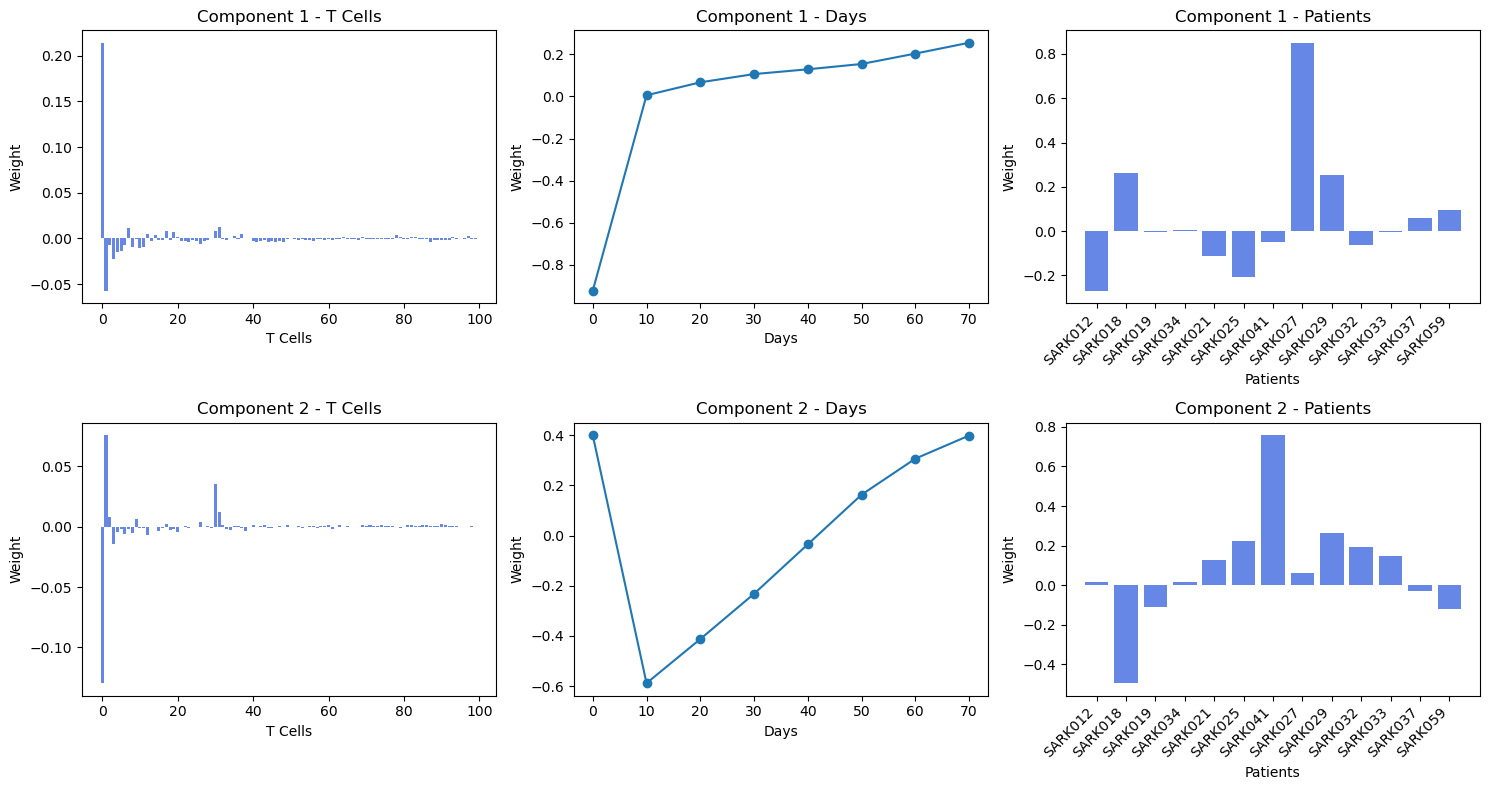

[1. 1.]


In [10]:
tensor_70_cent = tl.tensor(tensor_70_cent)
weights_70_cent, factors_70_cent = parafac(tensor_70_cent, rank=2, orthogonalise=True)
patients = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']
decomposition_visualization(factors_70_cent, patients)
print(weights_70_cent)

### Tensor 100_cent

#### PARAFAC

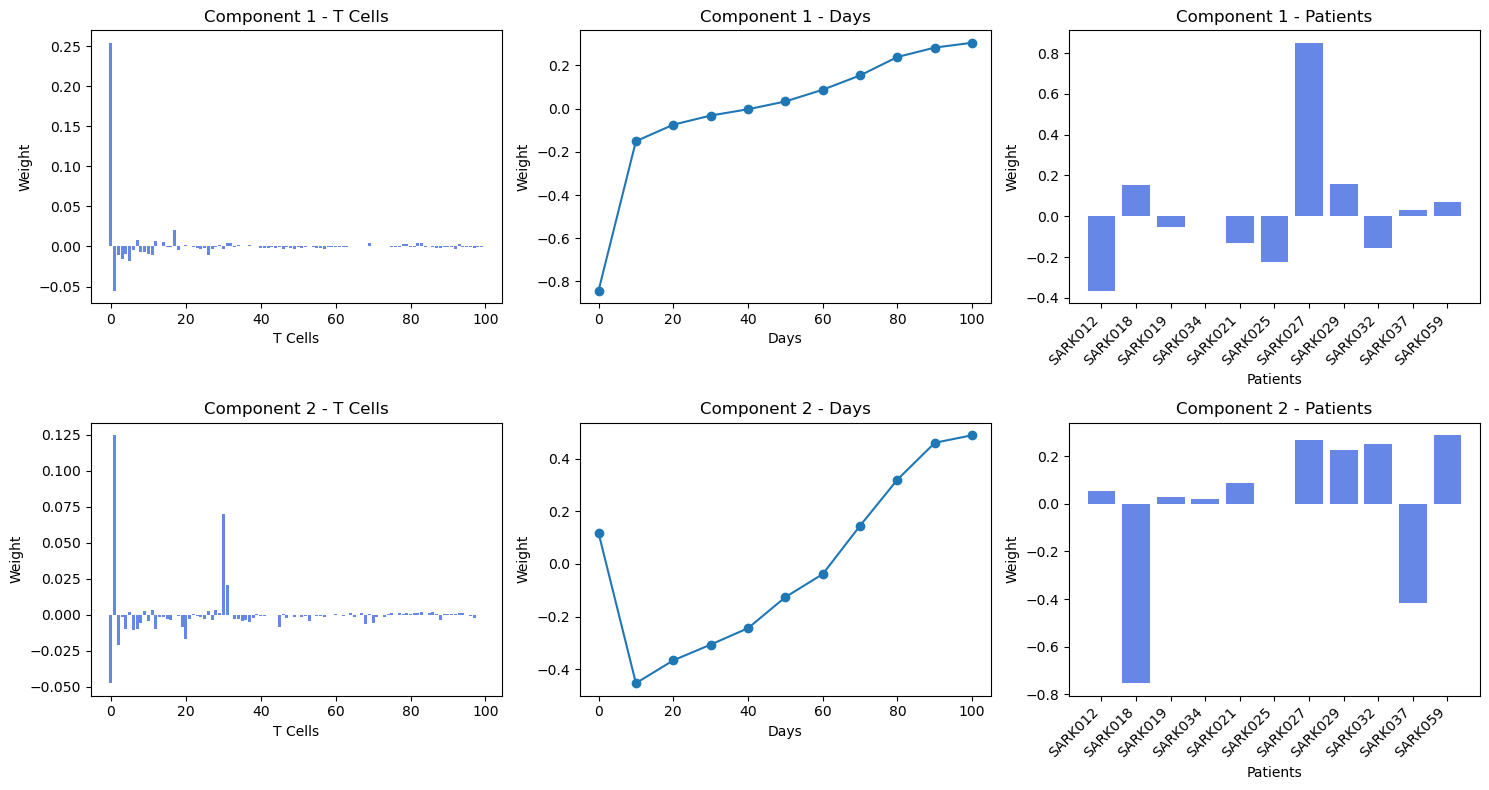

[1. 1.]


In [14]:
tensor_100_cent = tl.tensor(tensor_100_cent)
weights_100_cent, factors_100_cent = parafac(tensor_100_cent, rank=2, orthogonalise=True)
patients = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059']
decomposition_visualization(factors_100_cent, patients)
print(weights_100_cent)

### Tensor 200_cent

#### PARAFAC

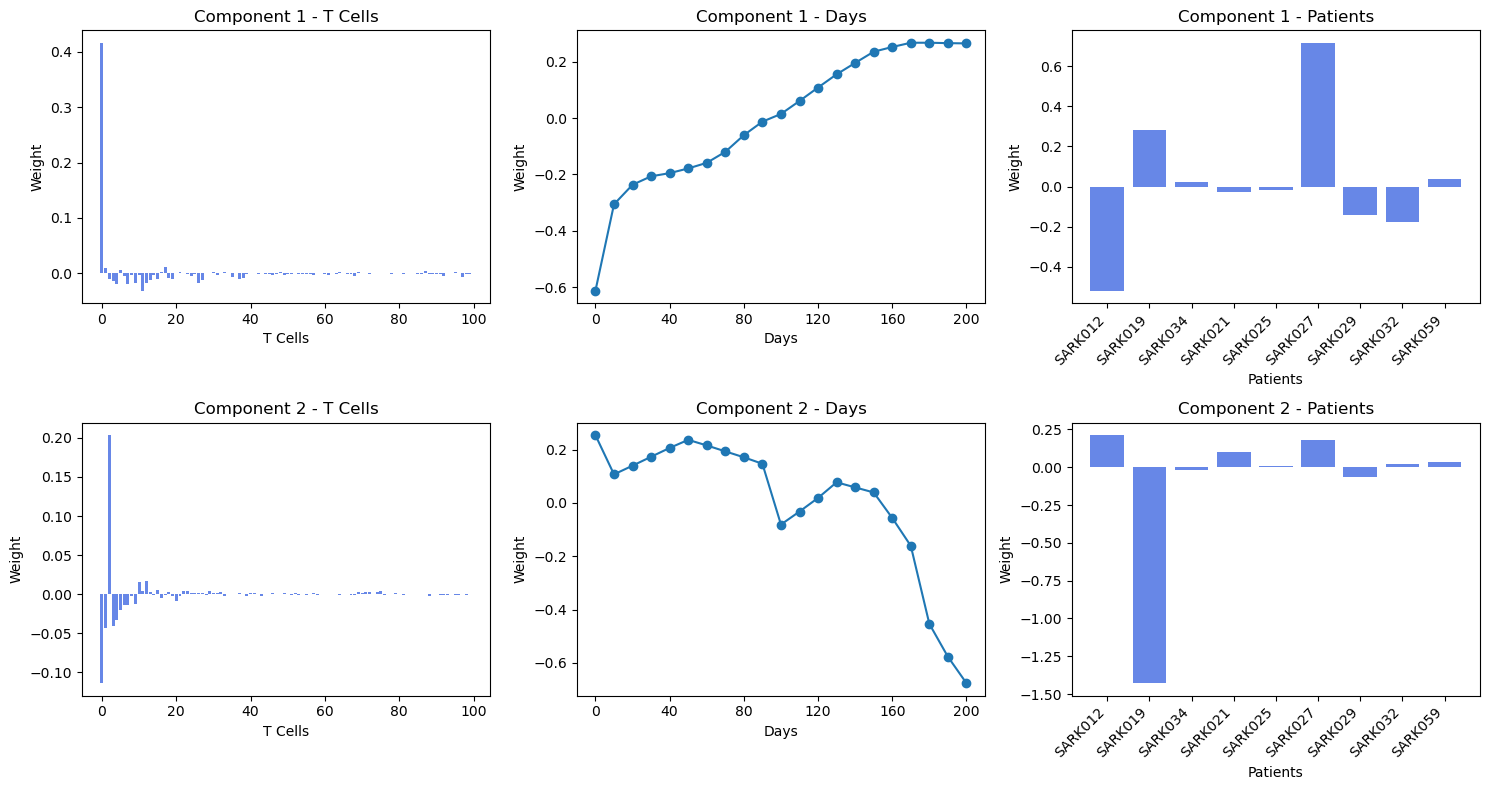

[1. 1.]


In [15]:
tensor_200_cent = tl.tensor(tensor_200_cent)
weights_200_cent, factors_200_cent = parafac(tensor_200_cent, rank=2, orthogonalise=True)
patients = ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK027', 'SARK029', 'SARK032', 'SARK059']
decomposition_visualization(factors_200_cent, patients)
print(weights_200_cent)

### Tensor 300_cent

#### PARAFAC

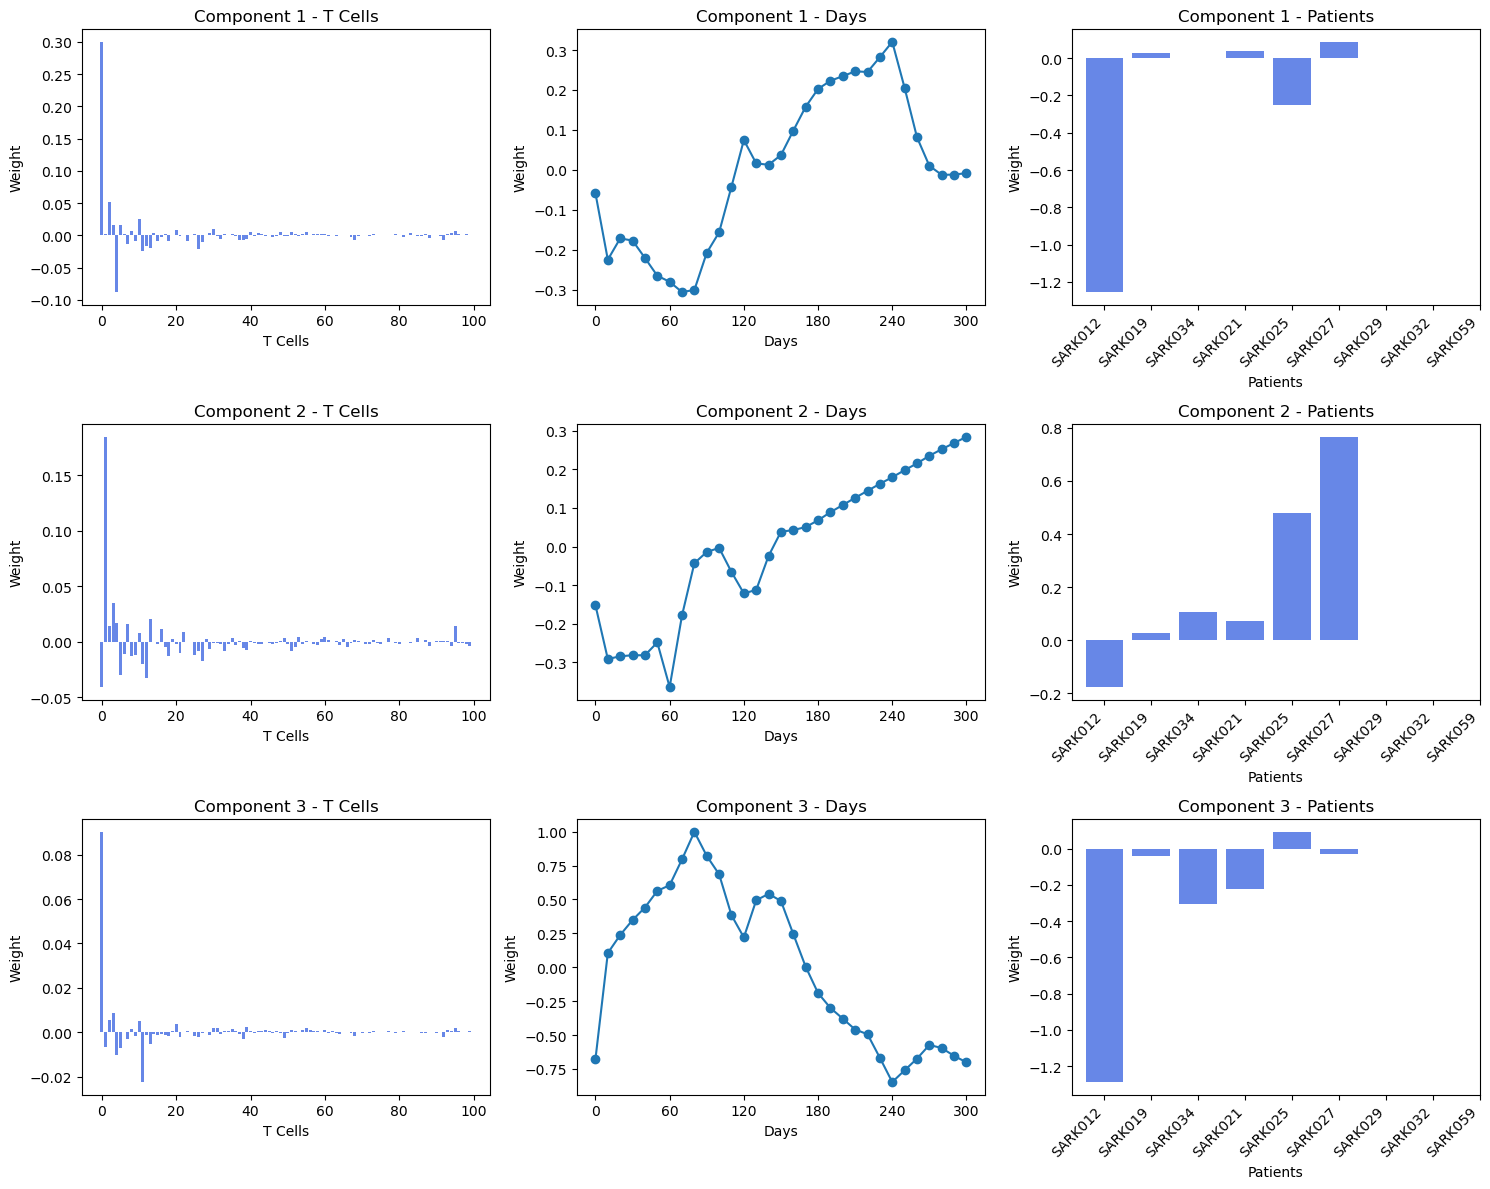

[1. 1. 1.]


In [18]:
tensor_300_cent = tl.tensor(tensor_300_cent)
weights_300_cent, factors_300_cent = parafac(tensor_300_cent, rank=3, orthogonalise=True)
patients = ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK027', 'SARK029', 'SARK032', 'SARK059']
decomposition_visualization(factors_300_cent, patients)
print(weights_300_cent)